In [ ]:
!pip install onnxruntime

In [ ]:
!git clone https://github.com/Kazuhito00/LDC-ONNX-Sample

In [ ]:
%cd LDC-ONNX-Sample

In [13]:
image_path = 'sample.jpg'
model_path = 'model/LDC_1920x1080.onnx'

In [14]:
import copy
import time

import cv2 as cv
import numpy as np
import onnxruntime


def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


def image_normalization(
    image: np.ndarray,
    image_min: int = 0,
    image_max: int = 255,
    epsilon: float = 1e-12,
) -> np.ndarray:
    image = np.float32(image)
    image = (image - np.min(image)) * (image_max - image_min) / (
        (np.max(image) - np.min(image)) + epsilon) + image_min
    return image


def run_inference(
    onnx_session: onnxruntime.InferenceSession,
    image: np.ndarray,
) -> np.ndarray:
    # ONNX Input Size
    input_size = onnx_session.get_inputs()[0].shape
    input_width = input_size[3]
    input_height = input_size[2]

    # Pre process:Resize, BGR->RGB, Transpose, float32 cast
    input_image = cv.resize(image, dsize=(input_width, input_height))
    input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
    input_image = input_image.transpose(2, 0, 1)
    input_image = np.expand_dims(input_image, axis=0)
    input_image = input_image.astype('float32')

    # Inference
    input_name = onnx_session.get_inputs()[0].name
    results = onnx_session.run(None, {input_name: input_image})

    # Post process
    image_width, image_height = image.shape[1], image.shape[0]
    for index, result in enumerate(results):
        temp = np.squeeze(result)
        temp = sigmoid(temp)
        temp = image_normalization(temp)
        temp = temp.astype(np.uint8)
        temp = cv.bitwise_not(temp)
        temp = cv.resize(temp, dsize=(image_width, image_height))

        results[index] = temp

    average_image = np.uint8(np.mean(results, axis=0))
    fuse_image = copy.deepcopy(results[index])

    return average_image, fuse_image

In [15]:
# Load model
onnx_session = onnxruntime.InferenceSession(
    model_path,
    providers=[
        'CUDAExecutionProvider',
        'CPUExecutionProvider',
    ],
)

start_time = time.time()

# Read image
image = cv.imread(image_path)
# Inference execution
average_image, fuse_image = run_inference(
    onnx_session,
    image,
)

elapsed_time = time.time() - start_time

print("Elapsed Time : " + '{:.1f}'.format(elapsed_time * 1000) + "ms")

cv.imwrite('average_image.png', average_image)
cv.imwrite('fuse_image.png', fuse_image)

Elapsed Time : 6039.1ms


True

In [16]:
_, threshold_image = cv.threshold(average_image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

In [17]:
# 細線化：THINNING_ZHANGSUEN
skeletonize_image_zhangsuen = cv.ximgproc.thinning(threshold_image, thinningType=cv.ximgproc.THINNING_ZHANGSUEN)
skeletonize_image_zhangsuen = cv.bitwise_not(skeletonize_image_zhangsuen)
cv.imwrite('skeletonize_image_zhangsuen.png', skeletonize_image_zhangsuen)

# 細線化：THINNING_GUOHALL 
skeletonize_image_guohall = cv.ximgproc.thinning(threshold_image, thinningType=cv.ximgproc.THINNING_GUOHALL)
skeletonize_image_guohall = cv.bitwise_not(skeletonize_image_guohall)
cv.imwrite('skeletonize_image_guohall.png', skeletonize_image_guohall)

True

Original Image


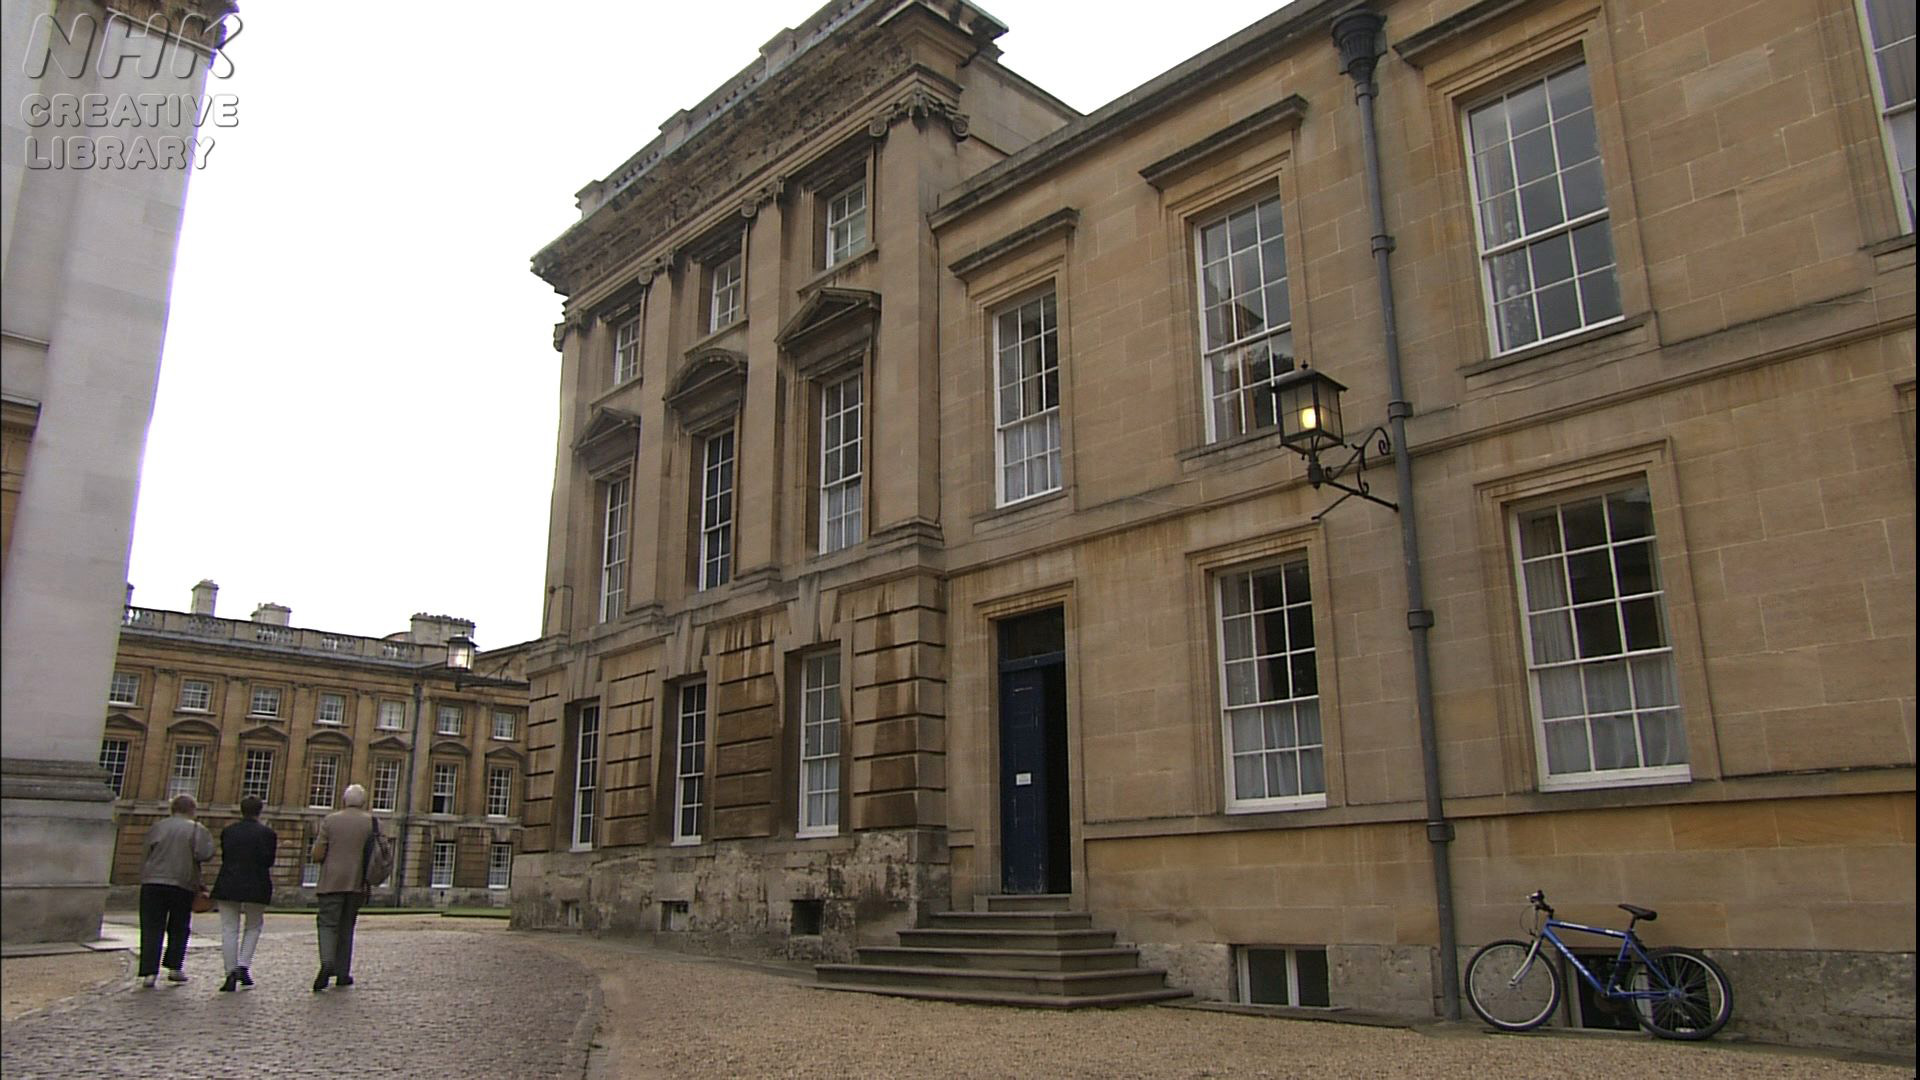


Fuse Image


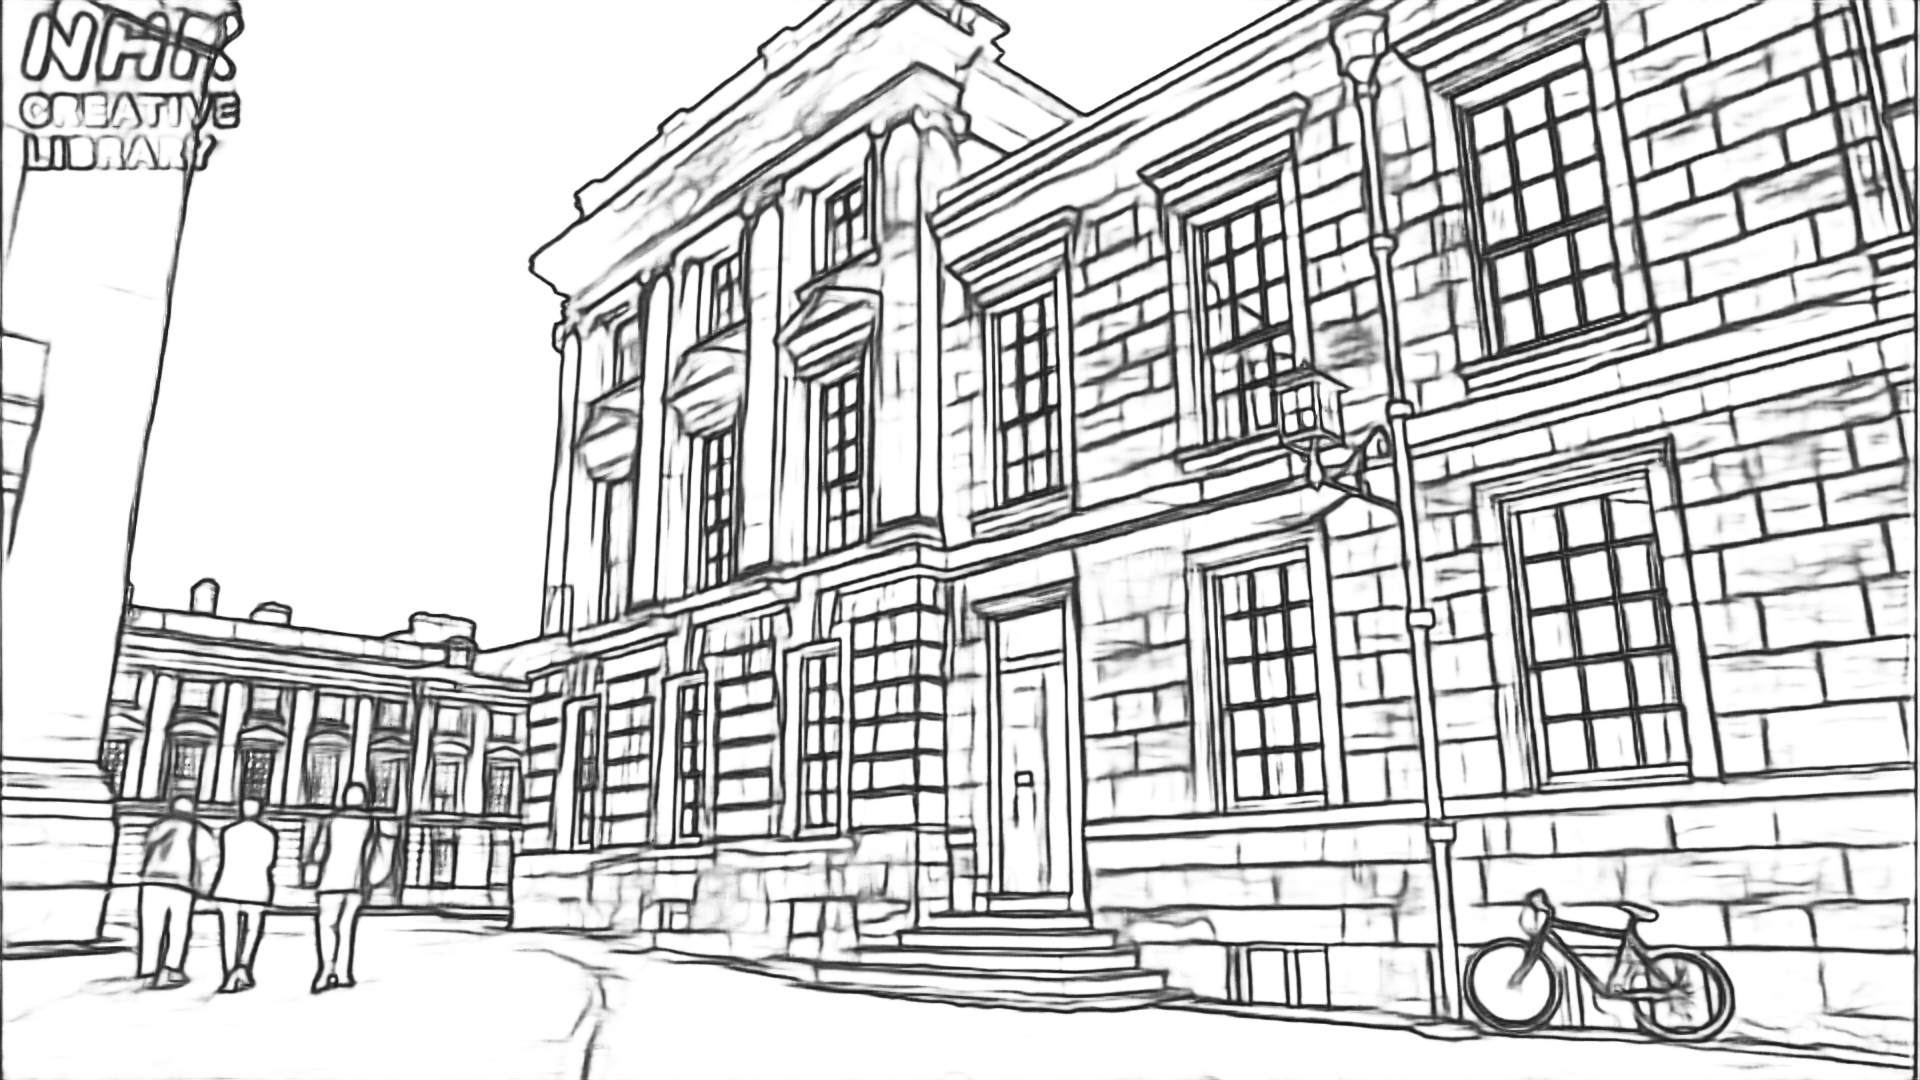


Average Image


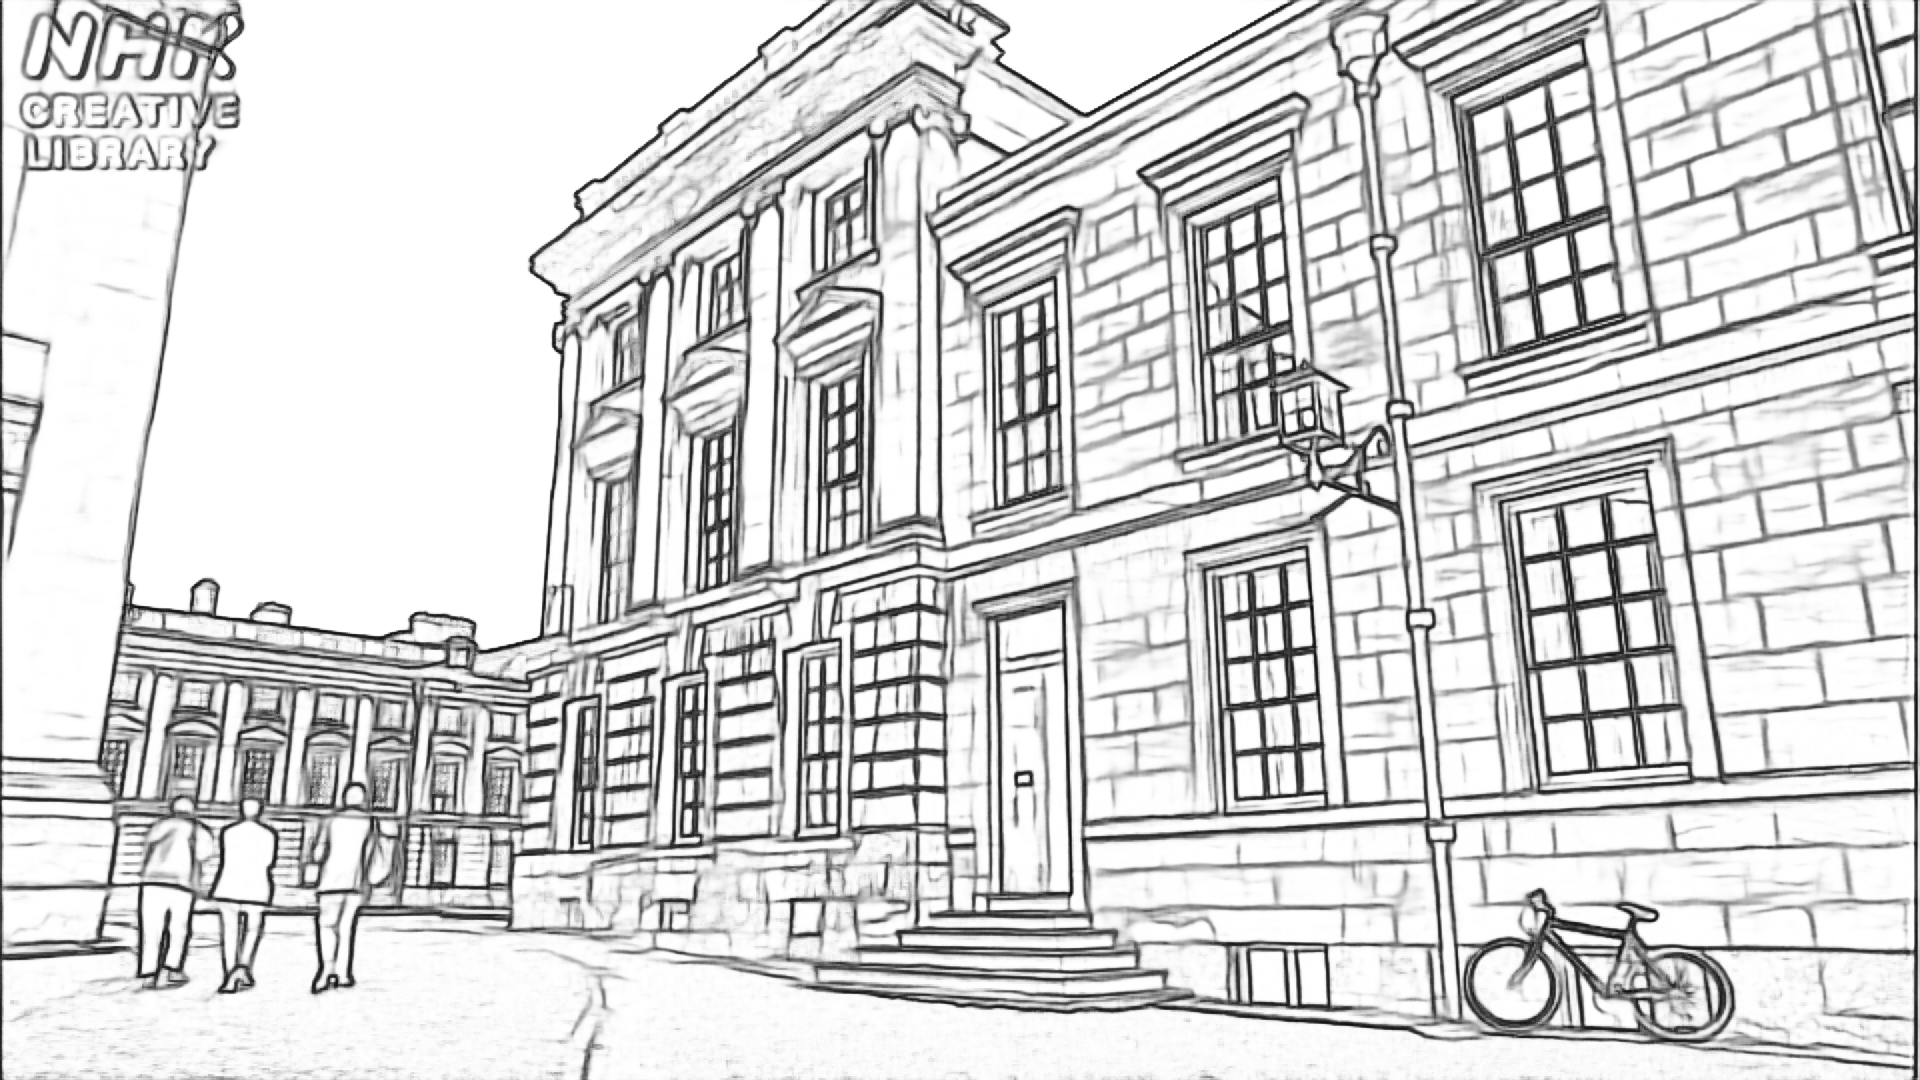


Threshold Image


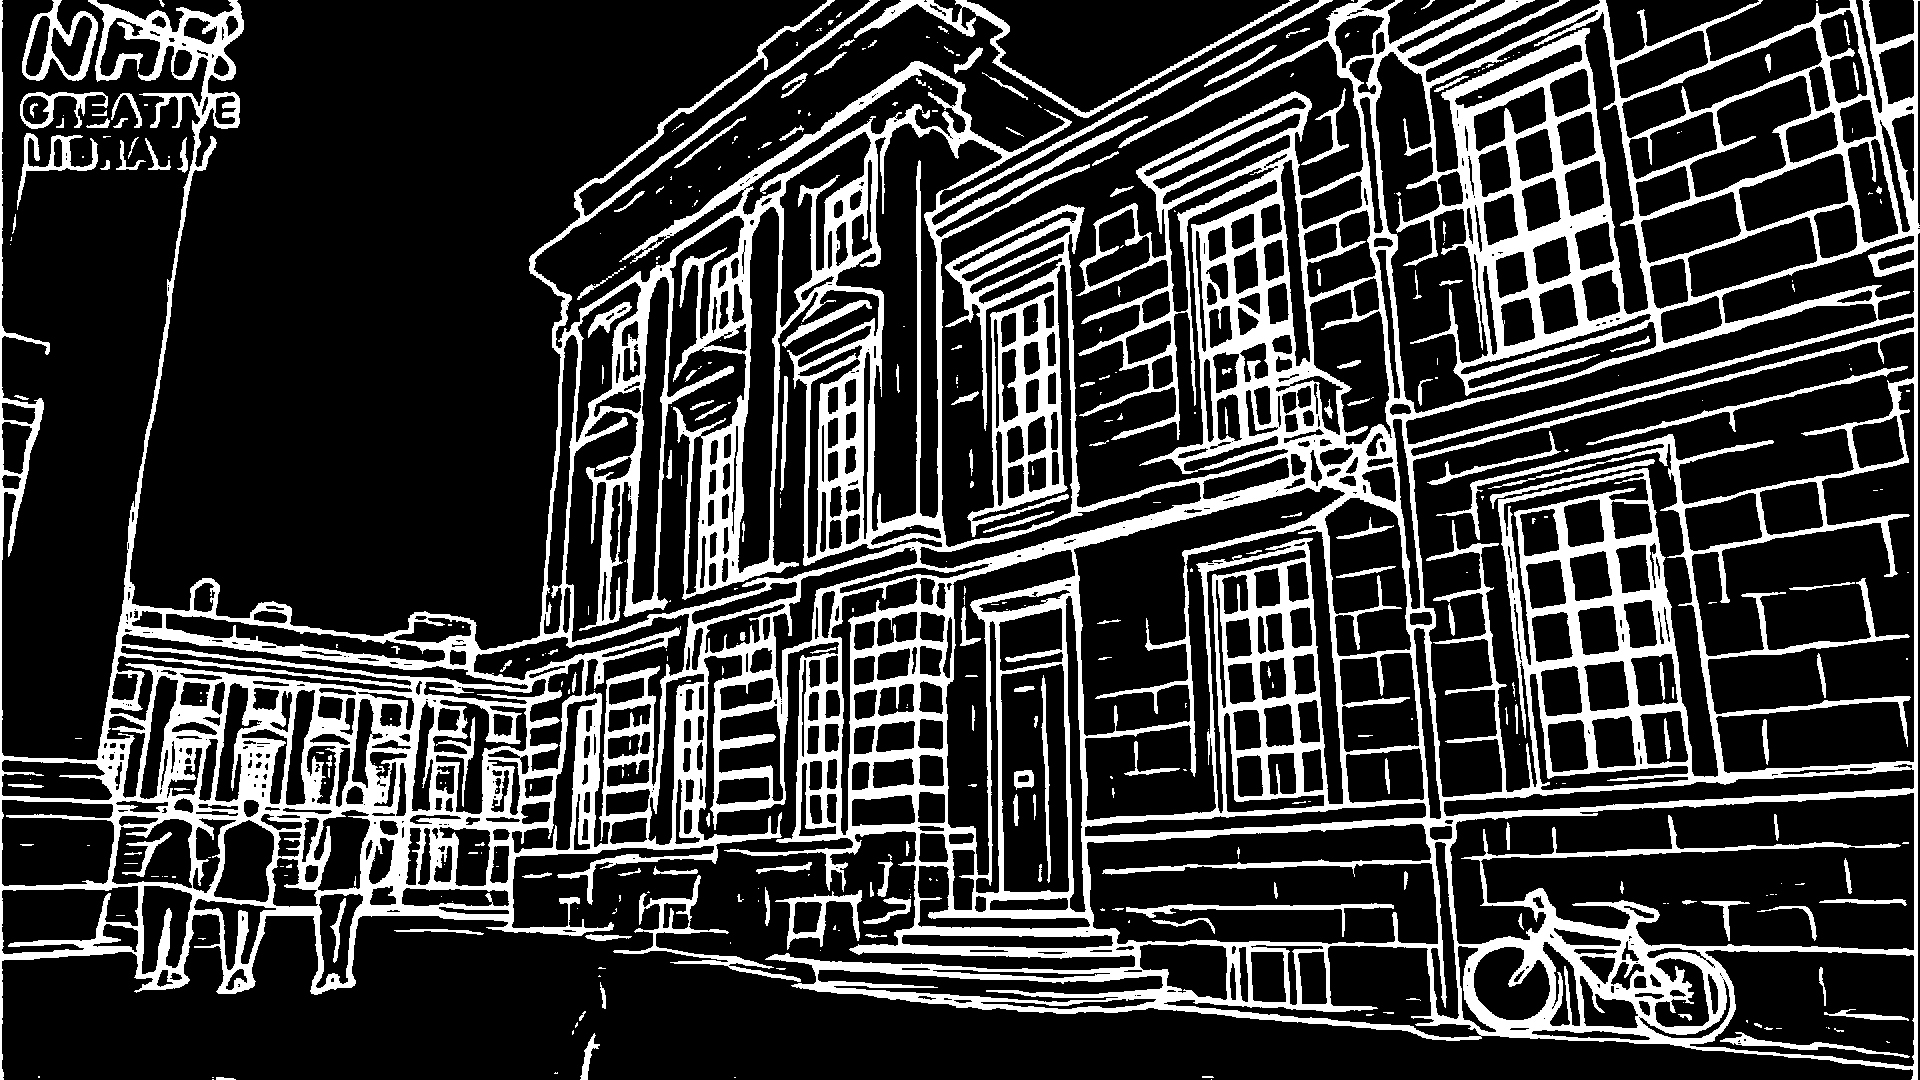


Skeletonize(ZHANGSUEN) Image


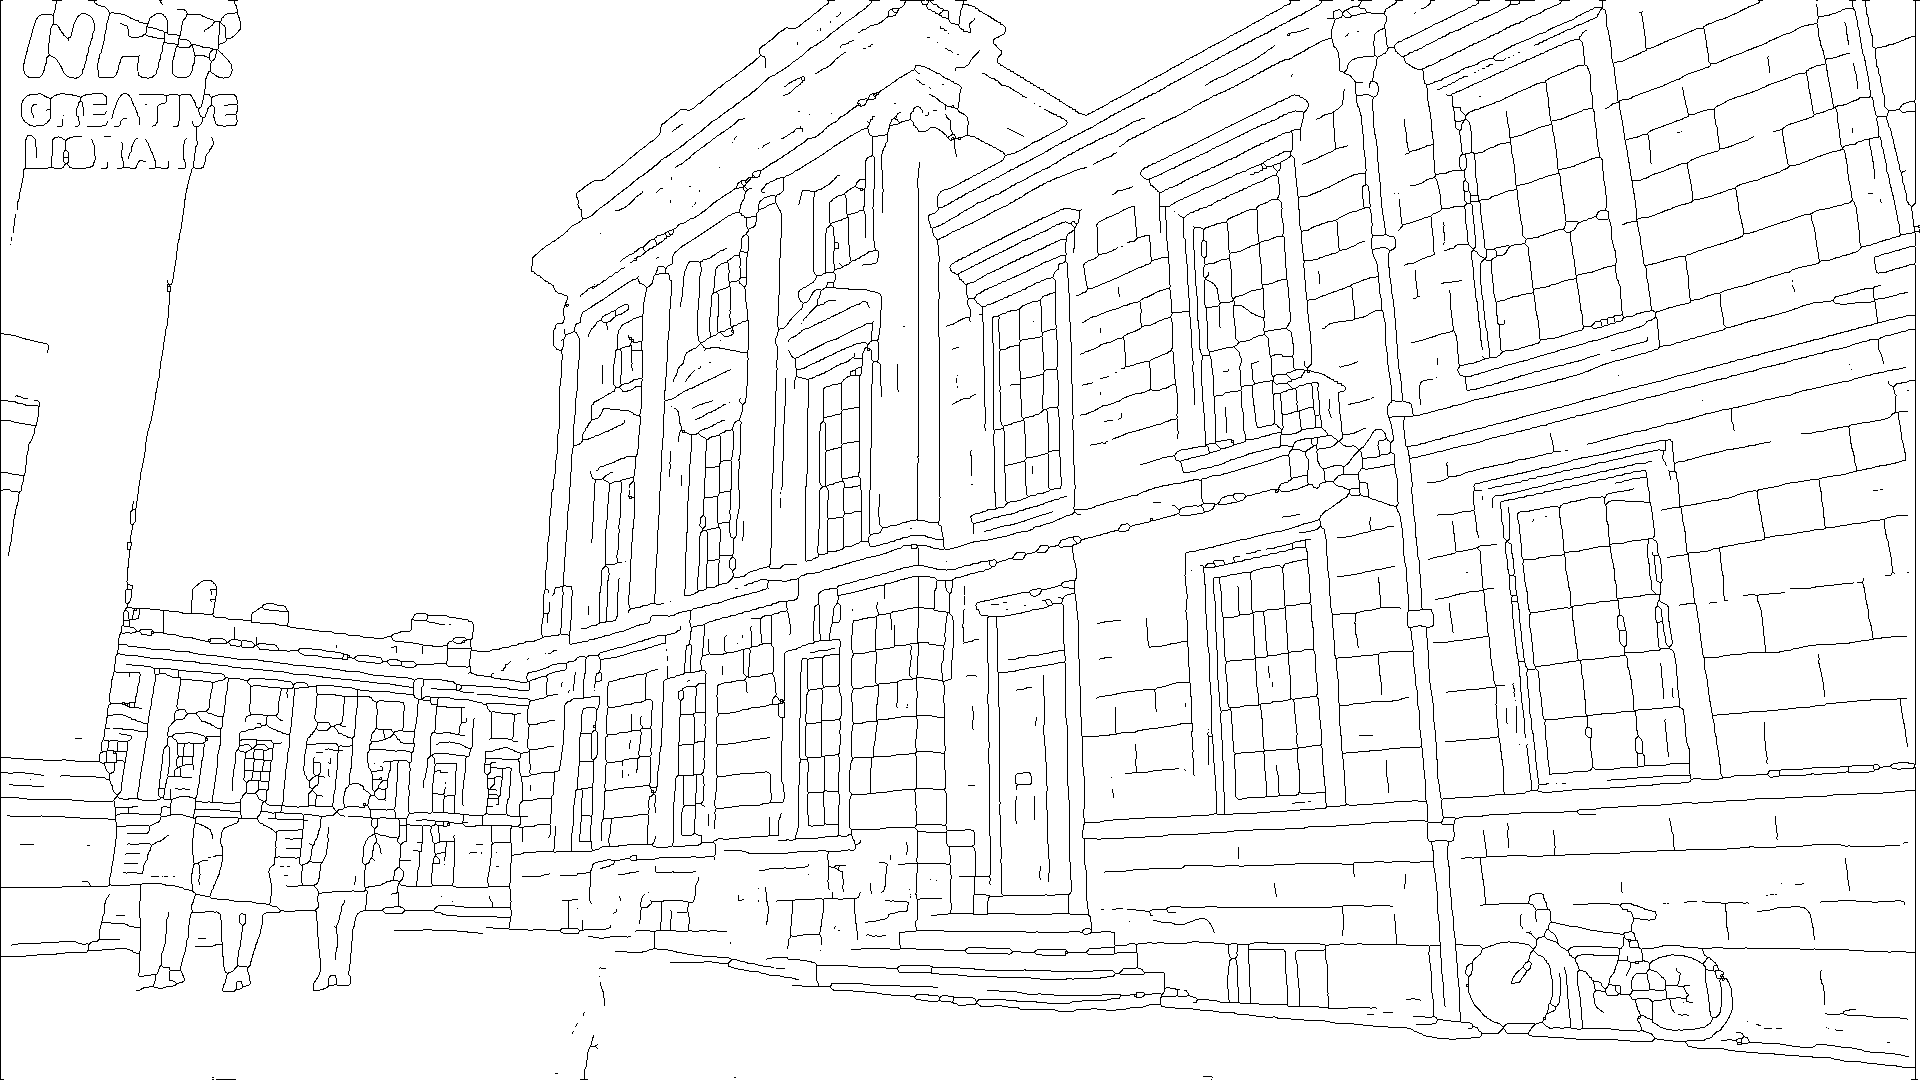


Original(GUOHALL) Image


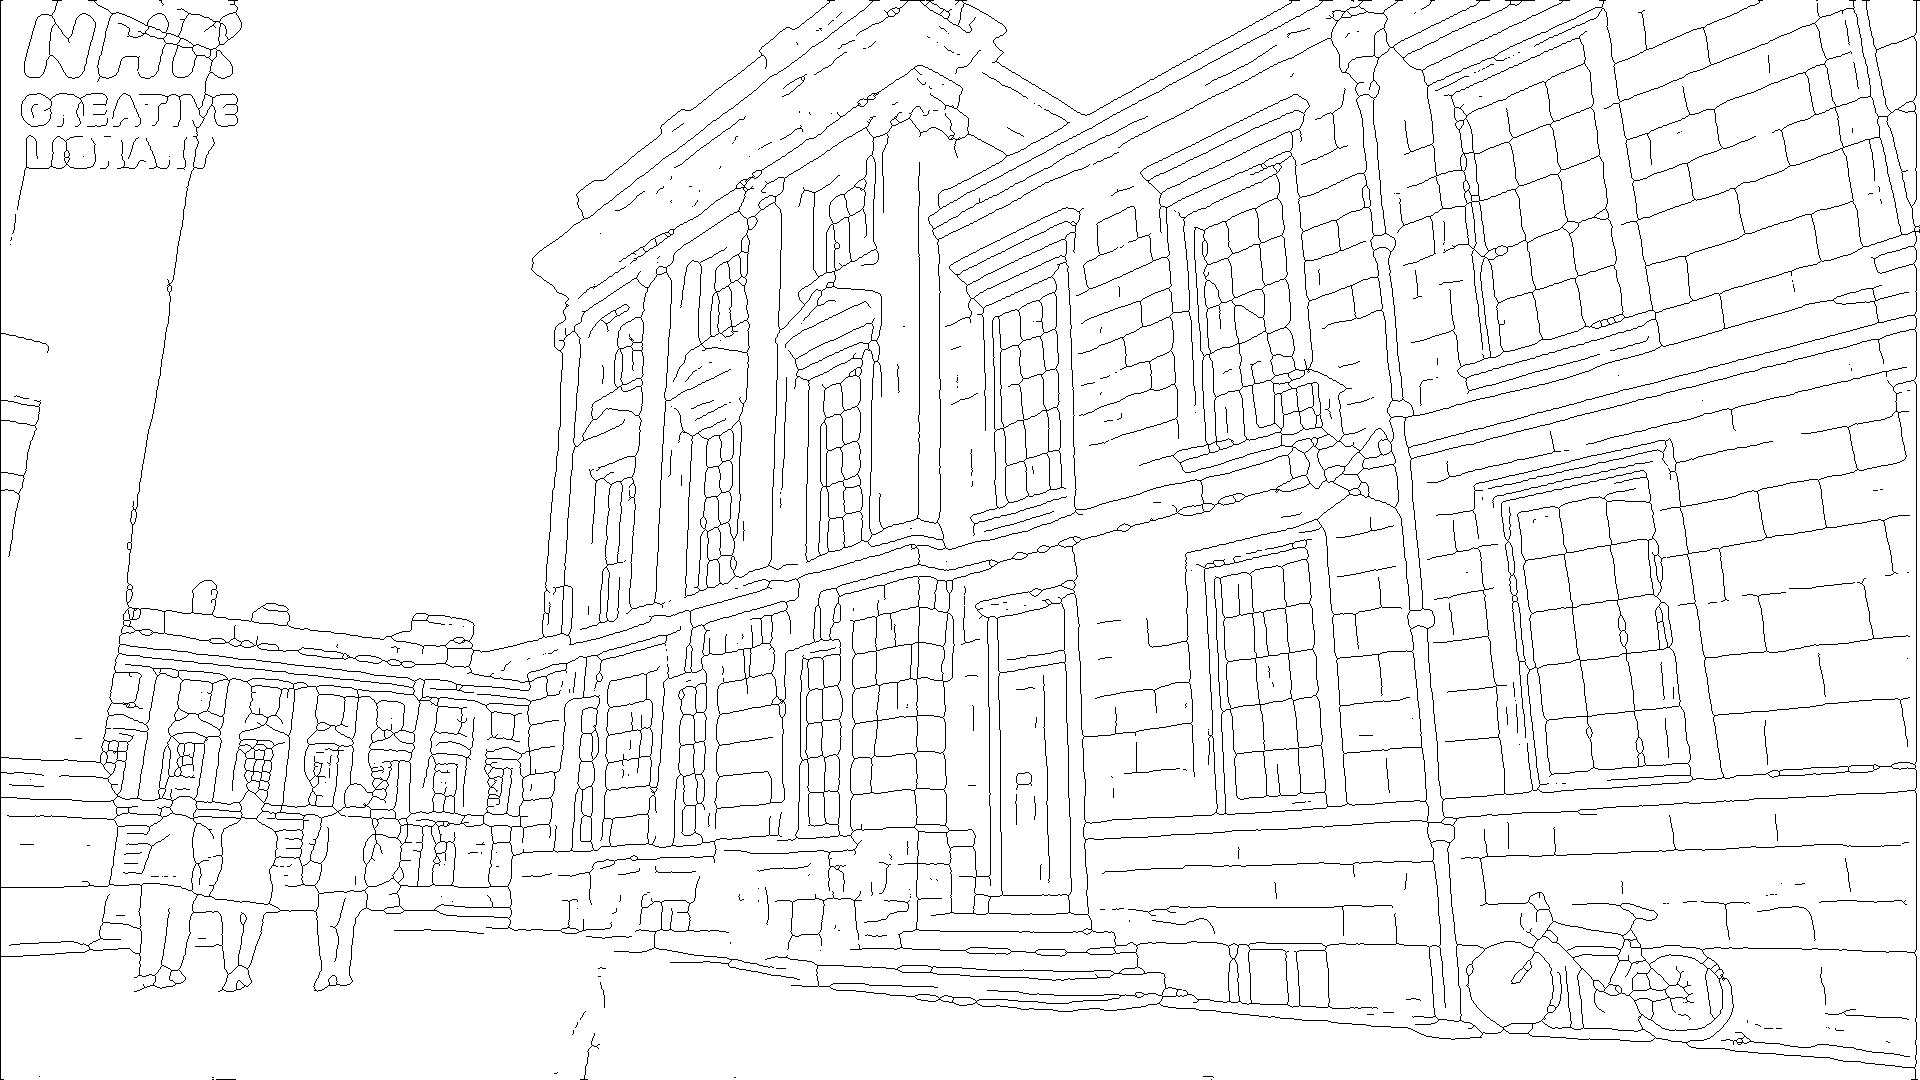

In [18]:
from google.colab.patches import cv2_imshow

print('Original Image')
cv2_imshow(image)

print('\nFuse Image')
cv2_imshow(fuse_image)

print('\nAverage Image')
cv2_imshow(average_image)

print('\nThreshold Image')
cv2_imshow(threshold_image)

print('\nSkeletonize(ZHANGSUEN) Image')
cv2_imshow(skeletonize_image_zhangsuen)

print('\nOriginal(GUOHALL) Image')
cv2_imshow(skeletonize_image_guohall)